#Imports

In [1]:
import time
#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
#
pd.set_option('display.max_columns', 500)  # force pandas to display all columns for better visual inspection
# plot plots inline
%matplotlib inline  

#Dataset IO

## Method 1: read from raw training set and sub sample

In [2]:
# Read training set into memory
trn = pd.read_csv('../data/train.csv')
# Generate random sample and save into file
trn_10 = trn.sample(frac=0.1)  # random sample 10% from whole sample
trn_10.to_csv('../data/train_10.csv')  # save randome sub-samples to a csv file
trn_1 = trn.sample(frac=0.01)  # random sample 1% from whole sample
trn_1.to_csv('../data/train_1.csv')  # save randome sub-samples to a csv file

## Method 2: read from temp file

In [2]:
trn_10 = pd.read_csv('../data/train_10.csv', index_col=0)  # column #0 in our file is index
# trn_1 = pd.read_csv('../data/train_1.csv', index_col=0)

In [4]:
print 'abc'

abc


# ML

## Cleaning

In [67]:
t = time.time()  # tic
## filter out observations with non-valid 'Ref'
# trn_1_withRef = trn_1[trn_1['Ref'].notnull()]
# trn_10_withRef = trn_10[trn_10['Ref'].notnull()]
trn_withRef = trn[trn['Ref'].notnull()]
print 'Time elapsed: {:.4f} secs'.format(time.time()-t)  # toc
## dimension checking
# print trn_1.shape, trn_1_withRef.shape, trn_1_withRef['Id'].nunique(), trn_1['Id'].nunique()
# print trn_10.shape, trn_10_withRef.shape, trn_10_withRef['Id'].nunique(), trn_10['Id'].nunique()
print trn.shape, trn_withRef.shape, trn_withRef['Id'].nunique(), trn['Id'].nunique()

Time elapsed: 1.1544 secs
(13765201, 24) (6349375, 24) 731556 1180945


In [39]:
np.percentile(trn['Expected'], [92])

array([ 54.700027])

In [40]:
trn_withRef_normal = trn_withRef[trn_withRef['Expected']<69]
trn_withRef_normal.shape

## Preprocessing 

### Combine observation

In [68]:
# Combine observations by 'Id'
t = time.time()
# trn_1_withRef_comb = trn_1_withRef.groupby('Id').agg(np.mean)
# trn_10_withRef_comb = trn_10_withRef.groupby('Id').agg(np.mean)
trn_withRef_comb = trn_withRef.groupby('Id').agg(np.mean)
print time.time()-t

2.72543311119


### Extract and split 

In [75]:
# Extract matrix-form data from pandas df
X = trn_withRef_comb.loc[:, 'minutes_past':'Kdp_5x5_90th'].values  # NOTE: used range slicing on column
y = np.log10(trn_withRef_comb['Expected'].values)

In [76]:
# Split data as training and validation set
[X_trn, X_val, y_trn, y_val] = train_test_split(X, y, test_size = 0.3)

### Missing values

In [77]:
# Deal with missing values
imp = Imputer(strategy='mean')  # Get a imputor with column-mean filling config
X_trn = imp.fit_transform(X_trn)
X_val = imp.fit_transform(X_val)

In [23]:
print X_trn.shape, X_val.shape, y_trn.shape, y_val.shape

(501554, 22) (219467, 22) (501554,) (219467,)


### Standardization

In [78]:
ss = StandardScaler(copy=False, with_mean=True, with_std=True)
ss.fit(X_trn, y_trn)
ss.transform(X_trn, y_trn)
ss.transform(X_val, y_val);

In [10]:
print X_trn.mean(axis=0), X_trn.std(axis=0)
print y_trn.mean(axis=0)
print X_val.mean(axis=0), X_trn.std(axis=0)
print y_val.mean(axis=0)

[ -1.77976619e-15  -8.08426142e-16  -4.10638395e-15  -2.96790570e-13
   3.71114292e-13  -5.46767881e-15  -9.18582740e-15   1.46280386e-12
  -4.31349270e-13  -3.57600921e-15  -2.40546578e-11   1.73638553e-11
  -1.18695831e-11   1.84742387e-11   7.71047974e-15  -1.51471881e-12
  -1.13648552e-12  -2.12249056e-12   9.70775509e-16  -4.47670098e-12
  -3.15835942e-13  -5.98200861e-13] [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.]
0.132255495602
[  3.33561724e-04  -1.05197622e-03  -2.36259527e-03   2.67887372e-03
   4.56473839e-04  -2.52234971e-06  -5.24222625e-04   2.96769854e-03
   1.96622799e-03   1.28064323e-03  -1.21186207e-03  -2.19198404e-03
   4.82979431e-03  -3.88093110e-03  -5.20908263e-03  -2.83781395e-03
   4.30704166e-03  -9.24050833e-03   5.77588363e-03   1.09066683e-03
  -1.22318025e-03   3.22538779e-03] [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.]
0.139758647943


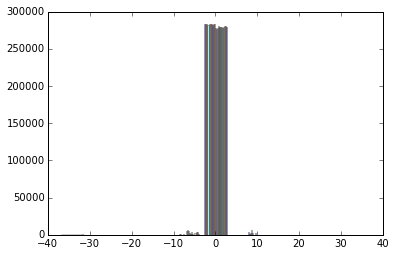

In [76]:
plt.hist(X_trn, alpha=0.3)
plt.show()

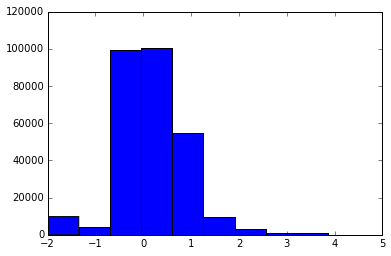

In [66]:
plt.hist(y_trn)
plt.show()

## Training and validation

In [79]:
t = time.time()
clf = RandomForestRegressor(n_jobs=-1)  # NOTE: n_jobs=-1 will use all of your cores, set to a prefered number
clf.fit(X_trn, y_trn)
y_val_predict = clf.predict(X_val)
print time.time()-t

30.929516077


## Performance evaluation 

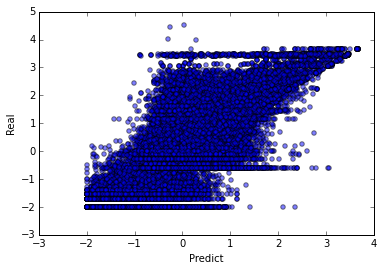

In [73]:
plt.scatter(y_val_predict, y_val, alpha=0.5)
plt.xlabel('Predict')
plt.ylabel('Real')

MAE = 18.3413626449


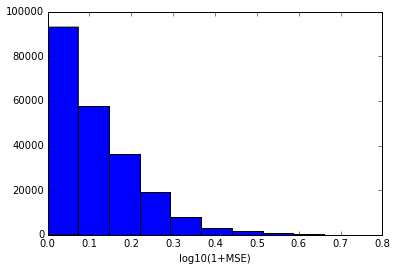

In [80]:
# Results with log10(y) + Standardization
print 'MAE = {}'.format(abs(10**y_val_predict-10**y_val).mean())
plt.hist(np.log10(1+abs(y_val_predict-y_val)))
plt.xlabel('log10(1+MSE)')

MAE = 16.8540568869


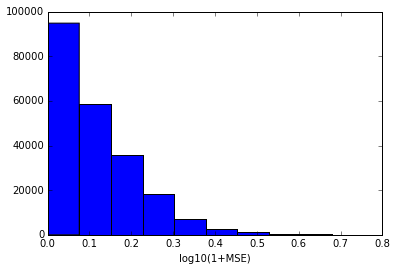

In [74]:
# Results with log10(1+y) + Standardization
print 'MAE = {}'.format(abs(10**y_val_predict-10**y_val).mean())
plt.hist(np.log10(1+abs(y_val_predict-y_val)))
plt.xlabel('log10(1+MSE)')

## Generate submission

In [81]:
test = pd.read_csv('../data/test.csv')
test_withRef = test[test['Ref'].notnull()]
test_withRef_comb = test_withRef.groupby('Id').agg(np.mean)
test_X = test_withRef_comb.loc[:, 'minutes_past':'Kdp_5x5_90th'].values
test_X = imp.fit_transform(test_X)
ss.transform(test_X)
test_y_predict = clf.predict(test_X)

In [82]:
test_result_withRef = pd.DataFrame()
test_result_withRef['Id'] = test_withRef_comb.index
test_result_withRef['Expected'] = test_y_predict

In [83]:
test_result = pd.DataFrame()
test_result['Id'] = test['Id'].unique()
test_result = pd.merge(test_result, test_result_withRef, how='left', on=['Id'], sort=True)
test_result.loc[test_result['Expected'].isnull(), 'Expected'] = -1
test_result
test_result.to_csv('../data/result.csv', index=False)

# Test code below

In [29]:
# print trn[trn['Id']==8]
print trn[trn['Ref'].isnull()]['Id'].nunique()
print trn['Id'].nunique()


907906
1180945


In [46]:
trn[trn['Ref'].isnull()&(trn['Id']==4)].head(20)

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,RefComposite_5x5_90th,RhoHV,RhoHV_5x5_10th,RhoHV_5x5_50th,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
35,4,23,9,NaN,NaN,NaN,26,7.5,12,18.5,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.064002
40,4,47,9,NaN,NaN,NaN,20,11.0,NaN,12.5,21.5,NaN,NaN,NaN,1.008333,NaN,NaN,NaN,0.5625,NaN,NaN,NaN,5.62999,4.064002
41,4,52,9,NaN,NaN,NaN,11,NaN,NaN,6.5,15.0,NaN,NaN,NaN,1.005000,NaN,NaN,NaN,0.5625,NaN,NaN,NaN,NaN,4.064002


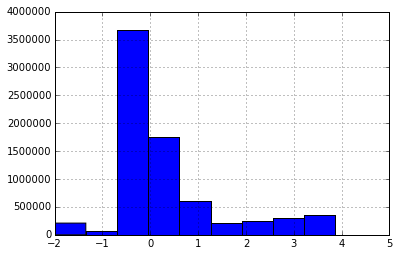

In [38]:
np.log10(trn[trn['Ref'].isnull()]['Expected']).hist()
# plt.show()

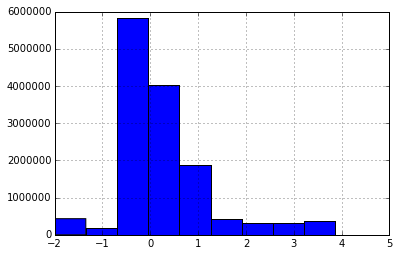

In [40]:
np.log10(trn['Expected']).hist()

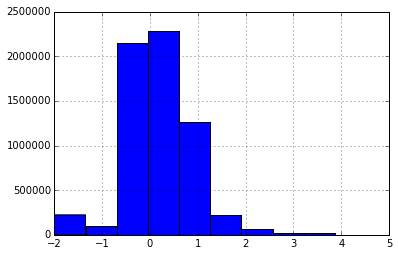

In [39]:
np.log10(trn[~trn['Ref'].isnull()]['Expected']).hist()

In [7]:
y_trn = y_trn.transpose()
y_val = y_val.transpose()

In [8]:
print y_trn.shape
print y_val.shape

(9635640L, 1L)
(4129561L, 1L)
